# Modelo: Predictor de Aprobación de Préstamos
### Autor: Manuel Mena
### Fecha: 3 de Octubre del 2019

### Introducción

El presente proyecto está referido al reto Independencia, el cual entrega una colección de datos de evaluación crediticia de clientes. Se solicita crear un modelo de machine learning para clasificar a aquellos clientes 
aptos para un préstamo.

Para fines de este notebook, se seguirá la metodologia propuesta por Garrett Grolemund y Hadley Wickham (2017), 
la cual establece etapas a efectuar en el proyecto, como la limpieza (tidy data) y transformación de datos, visualización, modelamiento y finalmente comunicación de resultados <https://r4ds.had.co.nz/introduction.html>.

Para fines de este proyecto se cuentan con los siguientes archivos:
* Archivo CSV de aprendizaje train.csv
* Archivo CSV de prueba test.csv
* Glosario de datos schema.png

Y los resultados del modelo de machine learning se deben entregar en:
* Archivo CSV de resultados outcome.csv

Este proyecto hará uso del lenguaje de programación R, el cual contiene funciones estadisticas apropiadas para el 
análisis interpretativo de datos, así como librerías para aplicar machine learning.

### 1. Etapa de carga de datos, limpieza y transformación

En esta primera etapa, se cargaran los archivos CSV, que contienen los datos que aplican a una solicitud crediticia. 
De manera breve diremos que un préstamo se otorga en base a variables como el monto del préstamo, la base financiera 
del solicitante como sus ingresos anuales, deudas y posesión de bienes, así como el monto que requiere de préstamo y 
el plazo de pago, entre otros.

En R, debemos cargar unas librerias de funciones que facilitan el procesamiento de datos:

In [1]:
# Cargar librerias para ejecucion del modelo -------------------------------------
suppressMessages(if(!require(tidyverse)) install.packages("tidyverse"))
suppressMessages(if(!require(caret)) install.packages("caret"))
suppressMessages(if(!require(maps)) install.packages("maps"))
suppressMessages(if(!require(e1071)) install.packages("e1071")) 
suppressMessages(if(!require(Rborist)) install.packages("Rborist"))
suppressMessages(if(!require(Rborist)) install.packages("ranger"))
suppressMessages(if(!require(wsrf)) install.packages("wsrf"))
suppressMessages(if(!require(monmlp)) install.packages("monmlp"))  
suppressMessages(if(!require(gbm)) install.packages("gbm"))
suppressMessages(if(!require(viridis)) install.packages("viridis"))

Procedemos entonces a leer los datos CSV para guardarlo como una tabla llamada "bank_data" y revisaremos como 
está su estructura:

In [2]:
bank_data <- read.csv("train.csv")
str(bank_data)

'data.frame':	1894 obs. of  14 variables:
 $ id                        : int  1267 1 2219 453 1108 989 1943 713 1836 2190 ...
 $ Loan.Amount               : num  25000 8000 11000 35000 35000 9500 20000 NA 4500 3300 ...
 $ Term                      : Factor w/ 3 levels ""," 36 months",..: 2 2 2 2 2 2 3 2 2 2 ...
 $ State                     : Factor w/ 49 levels "AK","AL","AR",..: 6 10 22 5 5 7 20 15 38 43 ...
 $ Annual.Income             : num  50000 65000 49000 108000 87000 ...
 $ Income.Verification.Status: Factor w/ 4 levels "","Not Verified",..: 3 3 4 4 3 4 4 2 2 2 ...
 $ Average.Account.Balance   : num  4073 2298 1441 33603 3399 ...
 $ Due.Amount                : num  783 264 3979 1154 1301 ...
 $ Home.Ownership            : Factor w/ 5 levels "","ANY","MORTGAGE",..: 4 5 3 3 5 5 5 3 5 4 ...
 $ Loan.Purpose              : Factor w/ 11 levels "car","credit_card",..: 2 3 3 2 3 3 3 9 3 9 ...
 $ Due.Settlement            : Factor w/ 3 levels "","N","Y": 2 3 2 3 3 2 2 3 3 2 ...
 $ Insta

Podemos observar de estos datos lo siguiente: 

* Se tienen 1894 registros con 13 variables y un predictor llamado Approve.Loan que define si se le dió prestamo o no.
* Existen datos vacios en el archivo, declarados como NA como en la variable Loan.Amount
* Existen clasificaciones vacias, como Term que contiene clases sin datos ""
* La variable Payment.Plan contiene solo un valor n con registros y uno sin clase ""
* El predictor es de tipo binario, si se otorgó prestamo "1" o no "0"


Los valores de predicción se deben convertir a una clase o "factor", y los datos con contenido vacio NA o clases 
vacias "" deben eliminarse o estimarse. Como primer modelo y debido a que una mala autorización de préstamos puede 
ser riesgosa, eliminaremos los datos incompletos.

In [3]:
bank_data[["Approve.Loan"]] <- factor(bank_data[["Approve.Loan"]])
bank_data[bank_data ==""] <- NA
bank_data <- droplevels(bank_data)
bank_data <- bank_data[complete.cases(bank_data),]
bank_data <- bank_data[,-13]

### 2. Etapa de visualización

En esta segunda etapa, procedemos a observar los datos y entender el comportamiento de las variables que definen un 
prestamo. Para ello ejecutamos un resumen de la tabla:

In [4]:
summary(bank_data)

       id          Loan.Amount            Term          State    
 Min.   :   0.0   Min.   : 1000    36 months:1092   CA     :215  
 1st Qu.: 616.5   1st Qu.: 8000    60 months: 304   TX     :129  
 Median :1273.0   Median :12700                     NY     :119  
 Mean   :1265.2   Mean   :15112                     FL     :113  
 3rd Qu.:1901.2   3rd Qu.:20000                     NJ     : 52  
 Max.   :2565.0   Max.   :40000                     NC     : 46  
                                                    (Other):722  
 Annual.Income         Income.Verification.Status Average.Account.Balance
 Min.   :  1000   Not Verified      :393          Min.   :    17         
 1st Qu.: 47000   Partially Verified:560          1st Qu.:  2936         
 Median : 66000   Verified          :443          Median :  6545         
 Mean   : 76871                                   Mean   : 12546         
 3rd Qu.: 90000                                   3rd Qu.: 17692         
 Max.   :530000             

A primera vista, observamos que el promedio de préstamo son USD 15,112. El plazo más común de solicitud de préstamo son 36 meses, el ingreso promedio de los solicitantes es USD 76,871, el estado de donde vienen más solicitudes es California con 215 requerimientos y la mayoría de solicitudes son para consolidación de deuda con 815 registros.

Nos interesa mucho observar como se distribuyen los montos de préstamo, ingresos y promedio en cuenta  según la aprobación brindada, para lo cual generamos la figura 1:

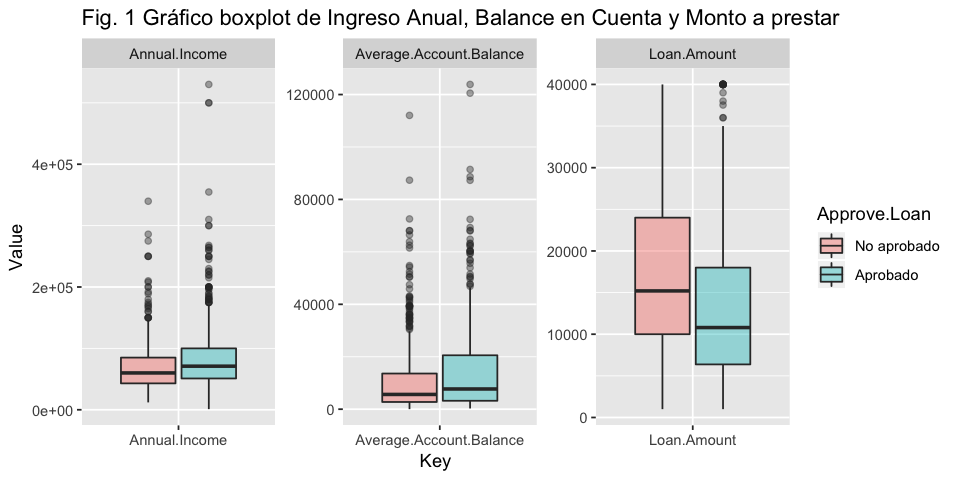

In [5]:
# Gráfico de cajas (boxplot) de monto de prestamo, ingresos anuales, promedio en cuenta
options(repr.plot.width = 8, repr.plot.height = 4)
bank_data %>% select(Loan.Amount, Annual.Income, Average.Account.Balance, Approve.Loan) %>% 
  mutate(Approve.Loan = recode(Approve.Loan,"0" = "No aprobado", "1" = "Aprobado")) %>% 
  gather(Key, Value, -Approve.Loan) %>% ggplot(aes(Key, Value, fill = Approve.Loan)) + 
  geom_boxplot(alpha = 0.4) + facet_wrap(~ Key, scales = "free") + 
  labs(title = "Fig. 1 Gráfico boxplot de Ingreso Anual, Balance en Cuenta y Monto a prestar")

Podemos observar en la figura 1 que la distribución de prestamos aprobados es mayor en solicitantes con una media mayor de ingresos, al igual que la media de balance promedio en cuenta. Sin embargo, la media de prestamos denegados es mayor en el monto de prestamos solicitado.

En la siguiente gráfica veremos la distribución de los montos adeudados y cuotas de pago que tienen los solicitantes:

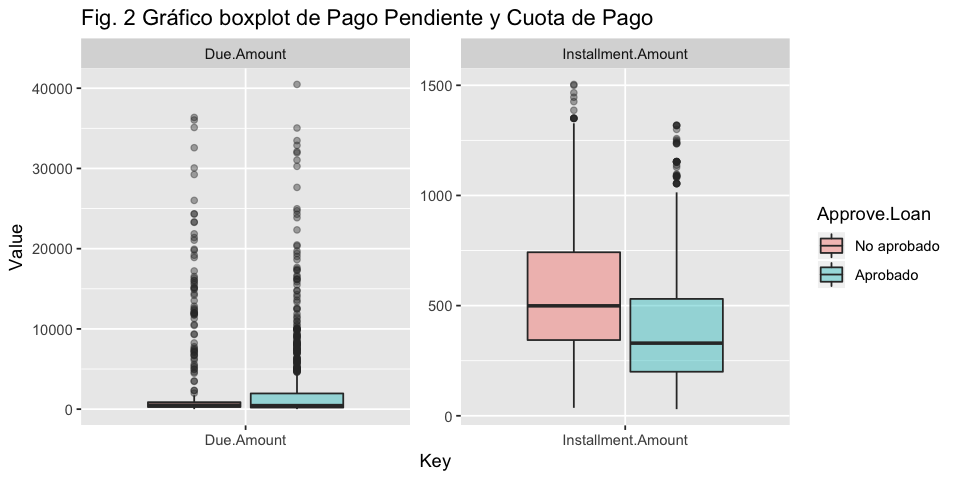

In [6]:
options(repr.plot.width = 8, repr.plot.height = 4)
bank_data %>% select(Due.Amount, Installment.Amount, Approve.Loan) %>% 
  mutate(Approve.Loan = recode(Approve.Loan,"0" = "No aprobado", "1" = "Aprobado")) %>% 
  gather(Key, Value, -Approve.Loan) %>% ggplot(aes(Key, Value, fill = Approve.Loan)) + 
  geom_boxplot(alpha = 0.4) + facet_wrap(~ Key, scales = "free") + 
  labs(title = "Fig. 2 Gráfico boxplot de Pago Pendiente y Cuota de Pago")

En el caso del monto de deuda de los solicitantes tienen una gran dispersión con deudas hasta los USD 40,000 pero con una mediana de USD 470 según los datos resúmen. En el caso de las cuotas que pagan los solicitantes, la mediana de los que no se les aprueba el préstamo es mayor que a los que sí se les aprueba.

Ahora procedemos a ver en la figura 3 como están compuestas las aprobaciones por plazo de préstamo:

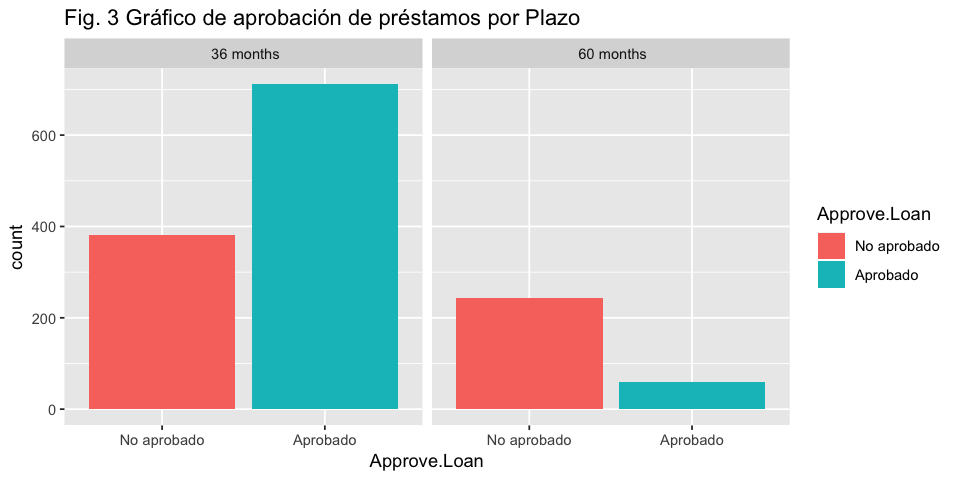

In [7]:
options(repr.plot.width = 8, repr.plot.height = 4)
bank_data %>% select(Term, Approve.Loan) %>% 
  mutate(Approve.Loan = recode(Approve.Loan,"0" = "No aprobado", "1" = "Aprobado")) %>%  
  ggplot(aes(Approve.Loan, fill = Approve.Loan)) + geom_bar() + facet_wrap(~ Term) + 
  labs(title = "Fig. 3 Gráfico de aprobación de préstamos por Plazo")

Como se observa en la figura 3, el plazo más solicitado y con más aprobación es el de 36 meses. El plazo de 60 meses es mayormente desaprobado.

Una de las variables de estos datos es la verificación de ingresos, que puede ser no verificado, verificado parcialmente y verificado. En la siguiente figura podremos observar cuantos préstamos aprobados y no aprobados se dan por esta variable:

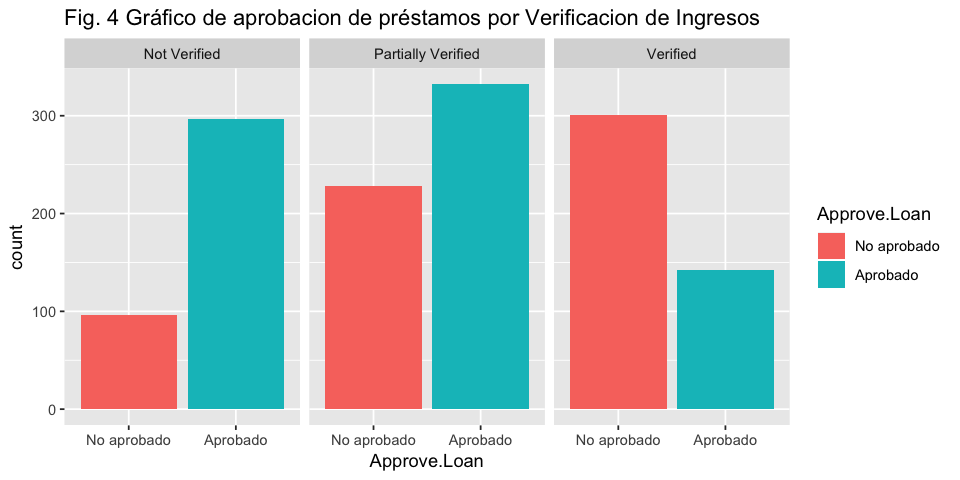

In [8]:
options(repr.plot.width = 8, repr.plot.height = 4)
bank_data %>% select(Income.Verification.Status, Approve.Loan) %>% 
  mutate(Approve.Loan = recode(Approve.Loan,"0" = "No aprobado", "1" = "Aprobado")) %>%  
  ggplot(aes(Approve.Loan, fill = Approve.Loan)) + geom_bar() + 
  facet_wrap(~ Income.Verification.Status) +  
  labs(title = "Fig. 4 Gráfico de aprobacion de préstamos por Verificacion de Ingresos")

En la figura 4 observamos que hay un monto mayor de prestamos aprobados para los clientes cuya verificación de ingresos no se ha hecho o se hizo parcialmente. 

Otra de las variables en los datos es la posesión de casa, que para el solicitante puede ser propietario, hipoteca, alquiler o otros. La siguiente figura muestra la relacion de cantidades de prestamos aprobados y no por dicha variable:

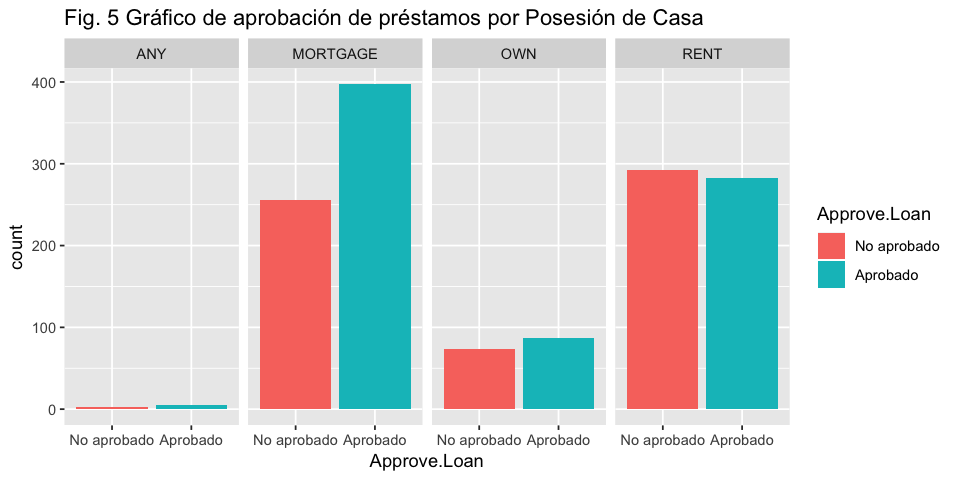

In [9]:
options(repr.plot.width = 8, repr.plot.height = 4)
bank_data %>% select(Home.Ownership, Approve.Loan) %>% 
  mutate(Approve.Loan = recode(Approve.Loan,"0" = "No aprobado", "1" = "Aprobado")) %>%  
  ggplot(aes(Approve.Loan, fill = Approve.Loan)) + geom_bar() + facet_wrap(~ Home.Ownership, ncol = 4) + 
  labs(title = "Fig. 5 Gráfico de aprobación de préstamos por Posesión de Casa")

Podemos observar que las cantidades mayores de aprobación se dan en los clientes con hipoteca, mientras que es casi parejo con los clientes con casa propia y alquilada.

El destino o fin de uso del prestamo es otra de las variables disponibles en los datos. Es una de las variables con mayor cantidad de categorias (11) por lo cual crearemos un gráfico para entender su relación:

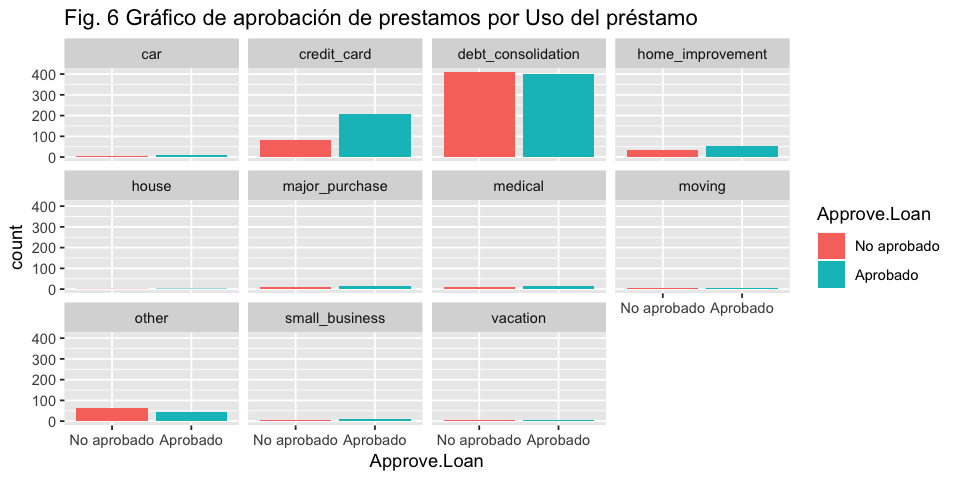

In [10]:
options(repr.plot.width = 8, repr.plot.height = 4)
bank_data %>% select(Loan.Purpose, Approve.Loan) %>% 
  mutate(Approve.Loan = recode(Approve.Loan,"0" = "No aprobado", "1" = "Aprobado")) %>%  
  ggplot(aes(Approve.Loan, fill = Approve.Loan)) + geom_bar() + facet_wrap(~ Loan.Purpose) + 
  labs(title = "Fig. 6 Gráfico de aprobación de prestamos por Uso del préstamo")

En la figura 6 pudimos notar que la mayor cantidad de prestamos se destina para uso de consolidación de deuda, tarjeta de crédito y mejora del hogar. La mayor cantidad de aprobación se da con la categoria tarjeta de crédito.

Los préstamos están categorizados por la variable "estado", lo cual nos lleva a un dato geográfico. Para tener un buen indicador, definimos el valor "ratio" el cual es la proporción de aprobaciones por cantidad de solicitudes. Podemos ver este gráfico en el siguiente mapa:

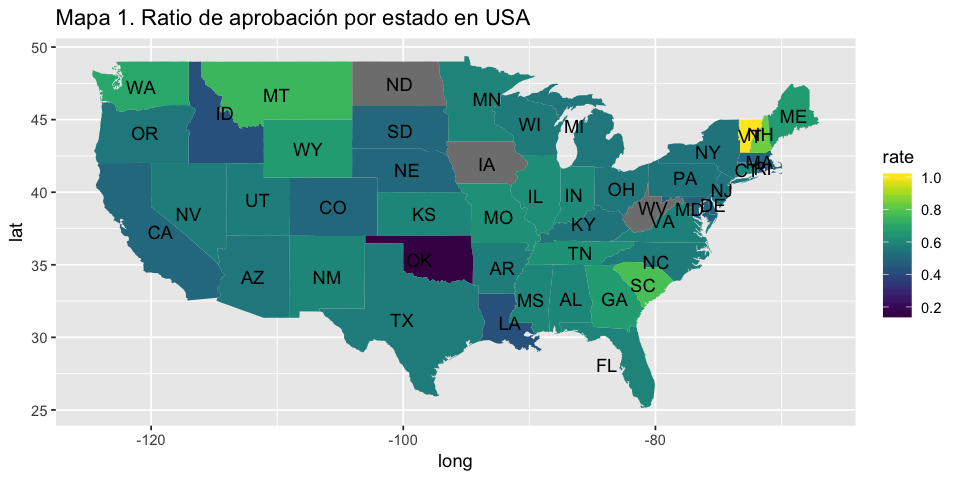

In [11]:
us_map <- map_data('state')
us_map$State <- state.abb[match(toupper(us_map$region), toupper(state.name))]
map_data <- bank_data %>% select(State, Approve.Loan) %>% group_by(State, Approve.Loan) %>% 
  summarise(count = n()) %>% mutate(rate = count / sum(count)) %>% filter(Approve.Loan == "1") 
options(warn=-1)
us_map <- left_join(us_map, map_data, by = "State")
centroids <- us_map %>% group_by(State) %>% 
  summarise(lat = mean(c(max(lat),min(lat))), 
            long = mean(c(max(long),min(long))))          
us_map %>% ggplot + geom_polygon(data = us_map, aes(x = long, y = lat, group = group, fill = rate)) + 
  scale_fill_viridis() + geom_text(data = centroids, aes(long, lat, label = State)) + 
  labs(title = "Mapa 1. Ratio de aprobación por estado en USA")

El mapa indica que el ratio de aprobación es mayor en Vermont y New Hampshire, mientras que Oklahoma tiene un ratio muy bajo de aprobación de préstamo. Los estado de Dakota del Norte, Indiana y West Virginia no registran aplicacion alguna, lo cual puede verse como una oportunidad para participar. 

### 3. Etapa de modelamiento

El reto de Independencia requiere crear un modelo de machine learning para clasificar a aquellos solicitantes quienes serían o no aprobados. La clasificación predice categorias discretas de tipo "si" "no", "viable" "no viable", etc. En forma resumida diremos que machine learning recorre las variables de un conjunto de datos y le asigna a cada una un peso para pronosticar en este caso si un cliente puede ser aprobado o no para un préstamo. El objetivo de esta etapa es hallar un modelo con una gran cantidad de aciertos posibles, a lo que llamaremos precisión.

Para iniciar, necesitamos un conjunto de datos con sus resultados para dividirlo en 2 partes, una de ellas servirá para el aprendizaje y la otra parte para la prueba. Con estas dos partes se va ensayando hasta encontrar un modelo óptimo. Este conjunto de datos lo obtendremos del archivo train.csv que fue convertido a bank_data. 

Procederemos entonces a crear estos 2 conjuntos que llamaremos train_set y test_set, en una proporción de 80% y 20% respectivamente. Asimismo, para que este modelo pueda ser reproducible por otras personas, definimos una semilla con el valor 1996. La semilla es un generador pseudo-aleatorio para simular que la división de los conjuntos fue al azar:

In [12]:
set.seed(1996)
data_index <- createDataPartition(bank_data$id, times = 1, p = 0.8, list = FALSE)
train_set <- bank_data[data_index,]
test_set <- bank_data[-data_index,]

Ahora con el conjunto de aprendizaje viene la selección del modelo de machine learning. En este caso de clasificación, usaremos los siguientes:

* Rborist: Que sirve para crear un conjunto de árboles de decisión (bosque)
* rf: Es otro modelo de arboles de decisión
* ranger: Un modelo adicional de arboles de decisión
* wsrf: Un modelo de arbol pero con pesos ponderados
* glm: Este modelo es el lineal generalizado
* monmlp: Esta es una red neuronal monótona
* gbm: Modelo de aceleración de gradientes o gradient boosting

Estos modelos se corren con una validación cruzada automática, es decir que el sistema divide el conjunto de aprendizaje en muchas partes y va corriendo el modelo hasta encontrar un valor de precisión óptimo. Este auto-proceso se llama bootstraping. 

In [13]:
options(warn=-1)
models <- c("Rborist","rf","ranger","wsrf","glm","monmlp","gbm")
fits <- lapply(models, function(model){
  print(model)
  train(Approve.Loan ~ ., method = model, data = train_set[,-1] )
})
names(fits) <- models

[1] "Rborist"
[1] "rf"
[1] "ranger"
[1] "wsrf"
[1] "glm"
[1] "monmlp"
** Ensemble 1 
Complex eigenvalues found for method = BFGS 
coefficients for function value 0.1470859  :
 [1] -3.282513e+04  9.024432e+03 -5.661244e+02 -1.186757e+02 -1.161211e+02
 [6] -7.218868e+02 -1.542379e+02 -3.208072e+03 -8.870390e+02  7.172020e+01
[11] -6.561170e+02 -6.503717e+01 -3.924954e+02 -8.839299e+02 -3.001464e+01
[16] -3.364653e+02 -2.144342e+03 -8.295099e+02 -2.695734e+01 -4.049469e+02
[21] -2.951475e+02  4.755736e-02 -4.859001e+02 -3.165129e+02 -6.570702e+02
[26] -2.391308e+02 -6.363910e+02 -3.076146e+02 -7.038366e-02 -3.216109e+02
[31] -1.034578e+03 -3.393751e+02 -1.278390e+02  5.621617e+01 -6.313013e+02
[36] -9.228035e+01  3.093803e+02 -1.859212e+02 -9.820401e+02 -1.600549e+02
[41] -7.421042e+03 -1.044432e+02  2.948867e+01 -8.063467e+02 -2.842902e+03
[46] -2.211728e+02 -1.163768e+03 -2.974641e+02 -3.513576e+02 -3.637728e+01
[51] -1.291911e+03 -1.878893e+02  7.129801e+01 -1.584953e+02 -1.799429e+02


Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3569             nan     0.1000    0.0099
     2        1.3340             nan     0.1000    0.0110
     3        1.3164             nan     0.1000    0.0081
     4        1.3021             nan     0.1000    0.0069
     5        1.2861             nan     0.1000    0.0077
     6        1.2709             nan     0.1000    0.0063
     7        1.2577             nan     0.1000    0.0053
     8        1.2460             nan     0.1000    0.0046
     9        1.2315             nan     0.1000    0.0059
    10        1.2224             nan     0.1000    0.0028
    20        1.1341             nan     0.1000    0.0025
    40        1.0317             nan     0.1000    0.0005
    60        0.9670             nan     0.1000    0.0005
    80        0.9221             nan     0.1000    0.0003
   100        0.8895             nan     0.1000   -0.0005
   120        0.8621             nan     0.1000   -0.0002
   140        

Ahora que están creados los modelos, procedemos a pronosticar en nuestro conjunto de pruebas test_set. 

In [14]:
pred <- sapply(fits, function(object) predict(object, newdata = test_set[,-1]))

La prueba de nuestros modelos es ver la precisión o cantidad de aciertos que tuvieron contra el valor real que está en la columna Approve.Loan, la cual hemos clasificado como "0" si no está aprobado, y "1" si está aprobado.

In [15]:
acc <- colMeans(pred == test_set$Approve.Loan)
acc

Rborist        rf    ranger      wsrf       glm    monmlp       gbm 
0.7536232 0.8007246 0.8079710 0.8224638 0.9094203 0.9275362 0.8695652

Los resultados o precisión de cada modelo de machine learning son valores entre 0 y 1, es decir entre menos preciso a más preciso. El promedio de precisión de estos siete modelos es:

In [16]:
mean(acc)

[1] 0.8416149

Podemos ver que el modelo con mayor precisión es el glm (Generalized Linear Model) con 90.94% de aciertos. El modelo con menor cantidad de aciertos fue el Rborist con una precisión de 75.36%. El promedio de precisión de todos los modelos fue de 84.16%.

Ahora, queremos entender que variables fueron las de mayor importancia en el modelo de mayor precisión. En este caso observamos el ranking de importancia del modelo glm:

In [17]:
varImp(fits$glm)

glm variable importance

  only 20 most important variables shown (out of 69)

                                               Overall
`Term 60 months`                               100.000
Installment.Amount                              95.215
Loan.Amount                                     93.868
Income.Verification.StatusVerified              46.461
`Income.Verification.StatusPartially Verified`  30.999
Annual.Income                                   20.686
Due.SettlementY                                 20.683
Loan.Purposecredit_card                         11.106
Loan.Purposemoving                               8.270
Loan.Purposemajor_purchase                       8.102
Average.Account.Balance                          6.624
Loan.Purposedebt_consolidation                   5.781
Home.OwnershipMORTGAGE                           4.257
Loan.Purposevacation                             4.101
Loan.Purposeother                                3.957
Due.Amount                               

Observamos que algunas variables representaron una gran importancia como se observó en los gráficos, por ejemplo el caso del plazo de 60 meses (60 months term) que los datos mostraban tenia menos aprobaciones que el plazo de 36. 

#### 3.1 El método ensemble

Para mejorar nuestra precisión usaremos un método que se llama ensemble. Para ello primero descartamos aquellos modelos cuyo desempeño sea menor que la promedio de 84% de precisión y luego, sobre los modelos que quedan se hará el método de voto simple: la clase más votada será elegida como prónostico para este ensemble. 

In [21]:
ind <- acc >= 0.84
votes <- rowMeans(pred[,ind]=="1")
y_hat <- ifelse(votes>0.5,"1","0")

Con los votos registrados, calculamos la precisión como promedio de todas las predicciones que fueron acertadas:

In [22]:
mean(y_hat==test_set$Approve.Loan)

[1] 0.9384058

Podemos observar que, con una muestra independiente del conjunto de aprendizaje pudimos alcanzar una precisión del 93.8%, mediante el modelo lineal generalizado glm, la red neuronal monótona monmlp y el acelerador de gradiente gbm.

### 4. Etapa de comunicación de resultados

Una vez probado el modelo, procedemos a crear el pronóstico para los datos de prueba, los cuales no tienen la columna Approve.Loan, por lo que desconocemos sus resultados. Los valores que obtengamos seguirán el mismo procedimiento realizado en el conjunto de aprendizaje, esto es verificar que no hayan datos vacios o nulos NA.

In [19]:
bank_data_test <- read.csv("test.csv")
str(bank_data_test)

'data.frame':	514 obs. of  13 variables:
 $ id                        : int  1601 1959 1174 634 2508 723 619 682 195 641 ...
 $ Loan.Amount               : num  21300 11000 16000 12000 5000 ...
 $ Term                      : Factor w/ 2 levels " 36 months"," 60 months": 1 1 1 2 1 1 1 1 1 1 ...
 $ State                     : Factor w/ 49 levels "AK","AL","AR",..: 18 33 14 38 5 43 35 9 43 38 ...
 $ Annual.Income             : num  47360 80000 89000 41000 20000 ...
 $ Income.Verification.Status: Factor w/ 3 levels "Not Verified",..: 3 1 1 2 3 2 2 3 2 3 ...
 $ Average.Account.Balance   : num  13879 2591 3019 4142 3448 ...
 $ Due.Amount                : num  791 357 10593 298 178 ...
 $ Home.Ownership            : Factor w/ 4 levels "ANY","MORTGAGE",..: 2 4 3 4 4 2 3 3 3 2 ...
 $ Loan.Purpose              : Factor w/ 11 levels "car","credit_card",..: 3 2 2 3 3 3 3 4 9 4 ...
 $ Due.Settlement            : Factor w/ 2 levels "N","Y": 2 2 1 2 2 1 1 1 2 2 ...
 $ Installment.Amount        : num 

Dado que los datos no tienen vacíos o nulos en las observaciones, procedemos a correr el modelo ensemble para obtener la predicción en la columna de datos Approve.Loan_test que es nuestro pronóstico, y guardar los resultados en un archivo de nombre outcome.csv: 

In [20]:
pred_test <- sapply(fits, function(object) 
  predict(object, newdata = bank_data_test %>% select(-1,-13)))

votes <- rowMeans(pred_test[,ind]=="1")
Approve.Loan_test <- ifelse(votes>0.5,"1","0")
outcome = data.frame(Approve.Loan_test)
outcome <- data.frame(id = bank_data_test$id, Approve.Loan = outcome$Approve.Loan_test)
write.csv(outcome, file = "outcome.csv", row.names = FALSE)                   

#### 4.1 Conclusiones

En base al análisis y modelo generado presentamos las siguientes conclusiones:

1. La secuencia de limpieza, visualización, modelamiento y comunicación presentaron de manera estructurada el proyecto del Independencia Challenge.
2. R contiene herramientas suficientes para el análisis estadístico, modelamiento en machine learning y presentación de datos, así como su integración a herramientas colaborativas como Jupyter Note.
3. La visualización con gráficos y resúmenes estadísticos son de gran ayuda para el análisis de variables de datos, detectar vacios y encontrar relaciones en la información.
4. Es posible combinar diversos modelos de Machine Learning como redes neuronales, árboles de decisión, aceleración de gradientes y modelos generalizados lineales mediante el metodo ensemble.
5. Gracias al método ensemble, hemos conseguido un modelo de clasificación con una precisión del 93%.
6. Este reporte finalmente ha seguido una explicación de como se llegaron a los resultados y es pertinente para tomar decisión sobre su uso en aplicaciones reales de préstamo.